In [ ]:
# Imports
import cv2
import os
import numpy as np
import pandas as pd
import shutil
import kagglehub
import keras

import tensorflow as tf
from keras.applications import ResNet50, MobileNetV2
from keras.applications.resnet50 import preprocess_input as resnet_preprocess
from keras import layers, models
from keras.models import Model
from keras.optimizers import Adam
from keras import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, LeakyReLU, BatchNormalization, Input, GlobalAveragePooling2D
from keras.src.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

# Visualization
import matplotlib.pyplot as plt

## Handtracking and Image modification
from cvzone.HandTrackingModule import HandDetector
from skimage.morphology import skeletonize
from skimage.measure import label, regionprops
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Projet - Air Drawing
---
## Membres équipe :
BAILLIEN Florian<br>
KINET Antoine<br>
RUYMAEKERS Axel

## 0) Introduction et présentation du projet
Nous avons choisi d’explorer la catégorie « Classification d’Images Avancée » avec une application pratique orientée vers la reconnaissance de caractères dessinés à la main, ce qui s’inscrit dans le cadre du projet "Air Drawing".

Notre démarche a été structurée autour de deux grandes approches complémentaires :
1) Conception et entraînement de réseaux de neurones convolutifs (CNN) "maison", construits de zéro.
2) Utilisation du Transfer Learning avec des modèles pré-entraînés populaires, tels que MobileNetV2 et ResNet50V2, en appliquant les techniques de feature extraction puis de fine-tuning.

Nous avons commencé par rechercher et sélectionner des datasets d’images adaptés, notamment des alphabets manuscrits (A-Z Handwritten Alphabets, EMNIST Letters et EMNIST By_Class), afin de disposer d’un jeu de données pertinent, équilibré et suffisamment riche pour entraîner nos modèles tout en respectant les contraintes techniques du projet.<br>
Ensuite nous avons entrainer chaque modèle et ressortis les graphique d'apprentissage dans le but d'ammener vers une conclusion de quel modèle était le plus performant, afin d'orienter la suite du projet.<br>
Enfin, nous avons validé notre travail par un test réel utilisant des images capturées en conditions concrètes via notre smartphone, afin d’évaluer la capacité du meilleur modèle à généraliser hors du cadre strict des données d’entraînement.


## 1) Datsets
---

### 1.1) A-Z Handwritten Alphabets
Le jeu de données A–Z Handwritten Characters est un ensemble de lettres manuscrites dérivé principalement du NIST Special Database 19 et d'autres sources comme N-MNIST. Il a été converti en images de 28x28 pixels en niveaux de gris, avec chaque lettre majuscule centrée dans un cadre de 20x20 pixels. Ce dataset comprend 26 classes (A à Z) et est destiné à l’entraînement de modèles de reconnaissance de lettres manuscrites. Bien que les images soient bien structurées en dossiers par lettre, le fichier CSV associé ne contient pas explicitement les labels, ce qui nécessite un traitement complémentaire pour l’utiliser directement en apprentissage supervisé.<br>
Nous avons donc chercher un DataSet plus général comprenant encore plus de données, surtout avec un label pour chaque données.

### 1.2) EMNIST
Le jeu de données EMNIST (Extended MNIST) est un ensemble de caractères manuscrits dérivé de la base de données NIST Special Database 19. Il a été converti au format d’image 28x28 pixels, avec une structure de données qui correspond directement à celle du jeu de données MNIST. EMNIST étend MNIST en incluant non seulement des chiffres, mais aussi des lettres majuscules et minuscules manuscrites, offrant ainsi un ensemble plus riche pour les tâches de reconnaissance de caractères.

In [4]:
# Télécharger dans le dossier par défaut non modifiable (cache de kagglehub)
dataset_path = kagglehub.dataset_download("crawford/emnist")

# Dossier cible
custom_path = "./Datasets/emnist_datasets"
os.makedirs(custom_path, exist_ok=True)

# Parcourir tout ce qu’il y a dans dataset_path
for item in os.listdir(dataset_path):
    src = os.path.join(dataset_path, item)
    dst = os.path.join(custom_path, item)
    shutil.move(src, dst)

100%|██████████| 1.24G/1.24G [02:04<00:00, 10.6MB/s]

Extracting files...


### 1.2.1) EMNIST (Letters)
Le jeu de données EMNIST Letters fusionne un ensemble équilibré de lettres majuscules et minuscules en une seule tâche de classification à 26 classes (une par lettre de l’alphabet).

- Entraînement : 88 800 images
- Test : 14 800 images
- Total : 103 600 images
- Nombre de classes : 26 (répartition équilibrée)


In [5]:
# Recupération des train_data de EMNIST Letters
def train_data_emnist_letters():
    return pd.read_csv('./Datasets/emnist_datasets/emnist-letters-train.csv', header=None).to_numpy()

# Recupération des test_data de EMNIST Letters
def test_data_emnist_letters():
    return pd.read_csv('./Datasets/emnist_datasets/emnist-letters-test.csv', header=None).to_numpy()

# Recupération des label_mapping de EMNIST Letters
def label_mapping_emnist_letters():
    return np.genfromtxt('./Datasets/emnist_datasets/emnist-letters-mapping.txt', delimiter=' ')

# Taille des fichiers d'entrainement
print(f"train_data_emnist_letters : {train_data_emnist_letters().shape}")
print(f"test_data_emnist_letters : {test_data_emnist_letters().shape}")

train_data_emnist_letters : (88800, 785)
test_data_emnist_letters : (14800, 785)


### 1.2.2) EMNIST (By_Class)
L'ensemble complet de la base de données EMNIST est disponible dans le sous-ensembles ByClass.
Le jeu ByClass contient 62 classes distinctes : les 10 chiffres (0–9), les 26 lettres majuscules (A–Z) et les 26 lettres minuscules (a–z).<br>
La répartition est déséquilibrée : certaines classes ont beaucoup plus d’exemples que d’autres.<br>
La fréquence des lettres reflète à peu près leur fréquence d'usage dans la langue anglaise.

__Taille des ensembles :__
- Entraînement : 697 932 images
- Test : 116 323 images
- Total : 814 255 images

__Classes :__
- ByClass : 62 classes (déséquilibrées)

In [6]:
# Recupération des train_data de EMNIST By_Class
def train_data_emnist_byclass(limit=250000):
    return pd.read_csv('./Datasets/emnist_datasets/emnist-byclass-train.csv', header=None, nrows=limit).to_numpy()

# Recupération des test_data de EMNIST By_Class
def test_data_emnist_byclass():
    return pd.read_csv('./Datasets/emnist_datasets/emnist-byclass-test.csv', header=None).to_numpy()

# Recupération des label_mapping de EMNIST By_Class
def label_mapping_emnist_byclass():
    return np.genfromtxt('./Datasets/emnist_datasets/emnist-byclass-mapping.txt', delimiter=' ')

# Taille des fichiers d'entrainement
print(f"train_data_emnist_byclass : {train_data_emnist_byclass().shape}")
print(f"test_data_emnist_byclass : {test_data_emnist_byclass().shape}")

train_data_emnist_byclass : (250000, 785)
test_data_emnist_byclass : (116323, 785)


Les test_data permet au modèle de voir s'il se généralise bien et qu'il ne fait pas du sur-apprentissage (évaluation époque par époque).
Pratique pour stopper ou débugger l'entrainement du modèle.

W


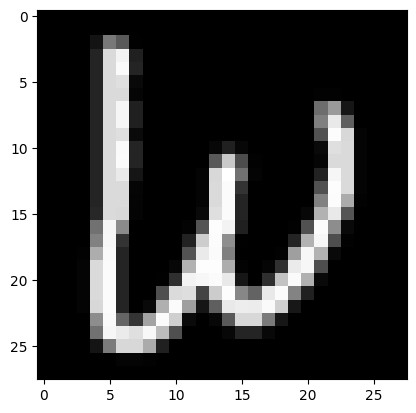

In [7]:
# Exemple de lettre contenue dans les DataSets EMNIST

label_mapping = label_mapping_emnist_byclass()
train_data = train_data_emnist_byclass()

label_trans = {}
for label_m in label_mapping:
    label_trans[label_m[0]] = chr(int(label_m[1]))

# Exemple d'une donnée EMNIST
img_nb = 150
print(label_trans[train_data[img_nb,0]])
plt.imshow(train_data[img_nb,1:].reshape(28,28).T, cmap='gray')
plt.show()

In [8]:
# Préparation des données :
def data_preparation(train_data, test_data, byclass=True):
    # 1) Séparation des labels "y" et les données de l'image "x"
    # Entrainement
    train_x = train_data[:,1:]
    train_y = train_data[:,0]
    # Test
    test_x = test_data[:,1:]
    test_y = test_data[:,0]

    # 2) Normalisation (valeur des "x" entre 0 et 1) -> Plus facile pour l'entrainement
    train_x = train_x / 255.0
    test_x = test_x / 255.0

    # 3) Reshape (Keras attend un format [batch_size, hauteur, largeur, canaux])
    train_count = train_x.shape[0]
    train_x = train_x.reshape(train_count, 28, 28)

    test_count = test_x.shape[0]
    test_x = test_x.reshape(test_count, 28, 28)

    # 4) Transposition des images (échanger lignes/colonnes)
    train_x = np.transpose(train_x, (0, 2, 1))  # Transposer chaque image car EMNIST à -90 degré
    test_x = np.transpose(test_x, (0, 2, 1))

    # 5) Transformation des labels (Chiffre en vecteur binaire)
    if byclass:
        num_classes = 62 # 62 catégorie dans By_Class allant de 0 à 61
    else:
        num_classes = 27 # 26 catégorie dans Letters mais allant de 1 à 26

    train_y = keras.utils.to_categorical(train_y, num_classes)
    test_y = keras.utils.to_categorical(test_y, num_classes)

    return train_x, train_y, test_x, test_y, num_classes

Nos données provenant du dataset EMNIST sont maintanant prêtes à etre utiliser dans nos différents modèle.

## 2) Augmentation de données
---

Nos données étant des lettres et chiffres, il est compliqué d'appliquer
des transformation trop importantes, une rotation trop forte peut rendre certaines
classes ambiguës (`6` vs `9`, `n` vs `u`...), nous avons donc choisi de ne pas appliquer de forte rotation.
Nous utiliserons donc `tf.keras.layers.RandomRotation(0.02)` pour prendre en compte des problemes
lors du dessin de la lettre sans rendre le résultat trop aléatoire.


Par contre, un zoom léger permet au modèle de mieux généraliser aux variations lié au geste.
Nous utiliserons donc `tf.keras.layers.RandomZoom(0.05)` pour l'augmentation de données

Nous n'avons pas utilisé `tf.keras.layers.RandomFlip` car un flip horizontal ou vertical
peux changer completement la lisibilité des lettres

## 3) Entrainement et constructions des modèles
---

### 3.1) Option A (CNN Maison)


#### 3.1.1) CCN Maison 1

##### Modèle

In [11]:
# Définition des données pour le premier modèle
train_x, train_y, test_x, test_y, num_classes = data_preparation(train_data_emnist_byclass(), test_data_emnist_byclass(), True)
# Modele séquentiel > Empiler les couches les unes apres les autres
model_cnn1 = Sequential()

# Couche d'augmentation de données
data_augmentation = keras.Sequential([
    keras.layers.RandomRotation(0.02),
    keras.layers.RandomZoom(0.05),
])

model_cnn1.add(keras.layers.InputLayer(input_shape=(28, 28, 1)))
model_cnn1.add(data_augmentation)  # <<< ici l'augmentation est ajoutée en première couche

# Creating conv layer 1
model_cnn1.add(Conv2D(32, kernel_size=(3, 3), activation='linear', padding='same'))
model_cnn1.add(LeakyReLU(alpha=0.1))
model_cnn1.add(MaxPooling2D((2, 2), padding='same'))
model_cnn1.add(Dropout(0.25))

# Creating conv layer 2
model_cnn1.add(Conv2D(64, (3, 3), activation='linear', padding='same'))
model_cnn1.add(LeakyReLU(alpha=0.1))
model_cnn1.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model_cnn1.add(Dropout(0.25))

# Adding the dense final part
model_cnn1.add(Flatten())
model_cnn1.add(Dense(1024, activation='linear'))
model_cnn1.add(LeakyReLU(alpha=0.1))
model_cnn1.add(Dropout(0.25))
model_cnn1.add(Dense(num_classes, activation='softmax'))

model_cnn1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_cnn1.summary()

C:\Users\Axel\Desktop\Air_Drawing\.venv\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
C:\Users\Axel\Desktop\Air_Drawing\.venv\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_5 (Sequential)       │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1024)           │     3,212,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 62)             │        63,550 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,294,654 (12.57 MB)

 Trainable params: 3,294,654 (12.57 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# Apprentissage du modèle et sauvegarde de celui-ci à la fin de son apprentissage et par époque
checkpoint = ModelCheckpoint('./Result/Models/model_cnn1_checkpoint.keras', save_best_only=True)

model_cnn1_history = model_cnn1.fit(train_x, train_y, validation_data=(test_x, test_y), epochs=10, callbacks=[checkpoint])
model_cnn1.save('./Result/Models/model_cnn1.keras')

7813/7813 ━━━━━━━━━━━━━━━━━━━━ 233s 30ms/step - accuracy: 0.8349 - loss: 0.4673 - val_accuracy: 0.8505 - val_loss: 0.4213
Epoch 3/10
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 233s 30ms/step - accuracy: 0.8428 - loss: 0.4366 - val_accuracy: 0.8581 - val_loss: 0.4015
Epoch 4/10
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 235s 30ms/step - accuracy: 0.8460 - loss: 0.4222 - val_accuracy: 0.8504 - val_loss: 0.4360
Epoch 5/10
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 236s 30ms/step - accuracy: 0.8478 - loss: 0.4137 - val_accuracy: 0.8552 - val_loss: 0.4120
Epoch 6/10
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 237s 30ms/step - accuracy: 0.8497 - loss: 0.4058 - val_accuracy: 0.8550 - val_loss: 0.4111
Epoch 7/10
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 238s 30ms/step - accuracy: 0.8524 - loss: 0.3978 - val_accuracy: 0.8573 - val_loss: 0.4015
Epoch 8/10
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 241s 31ms/step - accuracy: 0.8532 - loss: 0.3969 - val_accuracy: 0.8577 - val_loss: 0.3973
Epoch 9/10
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 243s 31ms/step - accuracy: 0.8546 - lo

##### Tableau d'apprentissage

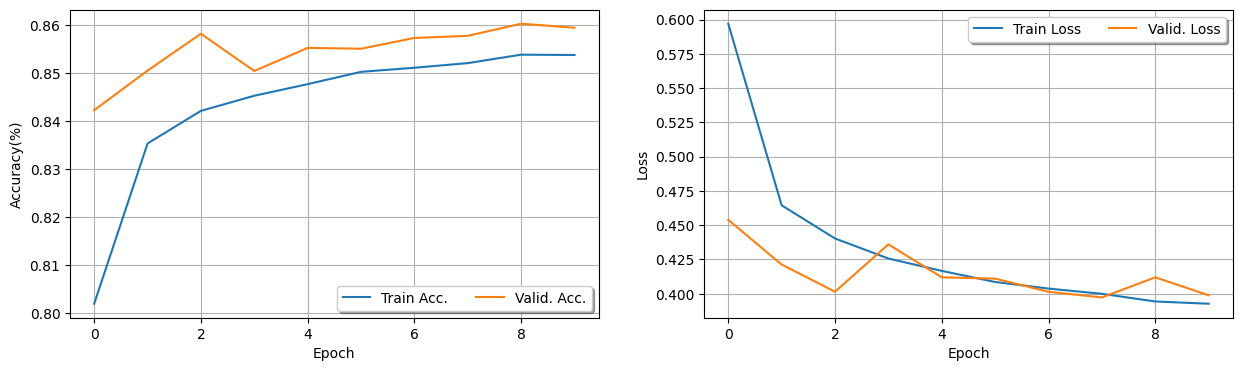

In [13]:
# Valeurs importantes lors de l'apprentissage du modèle
model_train_acc_cnn1 = model_cnn1_history.history['accuracy']
model_valid_acc_cnn1 = model_cnn1_history.history['val_accuracy']
model_train_loss_cnn1 = model_cnn1_history.history['loss']
model_valid_loss_cnn1 = model_cnn1_history.history['val_loss']

# Graphiques de l'apprentissage
fig,(ax0,ax1) = plt.subplots(1, 2, figsize=(15,4))

# Accuracy graph
ax0.plot(model_train_acc_cnn1, label="Train Acc.")
ax0.plot(model_valid_acc_cnn1, label="Valid. Acc.")

ax0.set_xlabel('Epoch')
ax0.set_ylabel('Accuracy(%)')
ax0.legend(loc='lower right', fancybox=True, shadow=True, ncol=4)
ax0.grid()

# Loss graph
ax1.plot(model_train_loss_cnn1, label="Train Loss")
ax1.plot(model_valid_loss_cnn1, label="Valid. Loss")

ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend(loc='upper right', fancybox=True, shadow=True, ncol=4)
ax1.grid()

#### 3.1.2) CCN Maison 2

##### Modèle

In [14]:
# Définition des données pour le deuxième modèle
train_x, train_y, test_x, test_y, num_classes = data_preparation(train_data_emnist_byclass(), test_data_emnist_byclass(), True)

# Définition du deuxième modèle
model_cnn2 = Sequential()

# Couche d'augmentation de données
data_augmentation = keras.Sequential([
    keras.layers.RandomRotation(0.02),
    keras.layers.RandomZoom(0.05),
])

# Ajout d'une couche d'input explicite pour la compatibilité
model_cnn2.add(keras.layers.InputLayer(input_shape=(28, 28, 1)))
model_cnn2.add(data_augmentation)  # <<< ajout de l'augmentation ici

# Convolution 1
model_cnn2.add(Conv2D(32, kernel_size=(3, 3), padding='same'))
model_cnn2.add(BatchNormalization())
model_cnn2.add(LeakyReLU(alpha=0.1))
model_cnn2.add(MaxPooling2D(pool_size=(2, 2)))
model_cnn2.add(Dropout(0.2))

# Convolution 2
model_cnn2.add(Conv2D(64, kernel_size=(3, 3), padding='same'))
model_cnn2.add(BatchNormalization())
model_cnn2.add(LeakyReLU(alpha=0.1))
model_cnn2.add(MaxPooling2D(pool_size=(2, 2)))
model_cnn2.add(Dropout(0.3))

# Convolution 3
model_cnn2.add(Conv2D(128, kernel_size=(3, 3), padding='same'))
model_cnn2.add(BatchNormalization())
model_cnn2.add(LeakyReLU(alpha=0.1))
model_cnn2.add(MaxPooling2D(pool_size=(2, 2)))
model_cnn2.add(Dropout(0.4))

# Dense layers
model_cnn2.add(Flatten())
model_cnn2.add(Dense(256))
model_cnn2.add(LeakyReLU(alpha=0.1))
model_cnn2.add(Dropout(0.5))

model_cnn2.add(Dense(num_classes, activation='softmax'))

# Compilation
model_cnn2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Résumé
model_cnn2.summary()

C:\Users\Axel\Desktop\Air_Drawing\.venv\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
C:\Users\Axel\Desktop\Air_Drawing\.venv\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_7 (Sequential)       │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_9 (LeakyReLU)       │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_10 (LeakyReLU)      │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_11 (LeakyReLU)      │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_12 (LeakyReLU)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 62)             │        15,934 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 404,670 (1.54 MB)

 Trainable params: 404,222 (1.54 MB)

 Non-trainable params: 448 (1.75 KB)

In [15]:
# Apprentissage du modèle et sauvegarde de celui-ci à la fin de son apprentissage et par époque
checkpoint = ModelCheckpoint('./Result/Models/model_cnn2_checkpoint.keras', save_best_only=True)

model_cnn2_history = model_cnn2.fit(train_x, train_y, validation_data=(test_x, test_y), epochs=10, callbacks=[checkpoint])
model_cnn2.save('./Result/Models/model_cnn2.keras')

Epoch 1/10
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 163s 21ms/step - accuracy: 0.6540 - loss: 1.2348 - val_accuracy: 0.8417 - val_loss: 0.4557
Epoch 2/10
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 159s 20ms/step - accuracy: 0.8065 - loss: 0.5657 - val_accuracy: 0.8471 - val_loss: 0.4249
Epoch 3/10
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 159s 20ms/step - accuracy: 0.8156 - loss: 0.5293 - val_accuracy: 0.8535 - val_loss: 0.4051
Epoch 4/10
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 159s 20ms/step - accuracy: 0.8253 - loss: 0.5019 - val_accuracy: 0.8506 - val_loss: 0.3991
Epoch 5/10
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 160s 21ms/step - accuracy: 0.8275 - loss: 0.4910 - val_accuracy: 0.8592 - val_loss: 0.3877
Epoch 6/10
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 162s 21ms/step - accuracy: 0.8304 - loss: 0.4837 - val_accuracy: 0.8559 - val_loss: 0.3919
Epoch 7/10
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 163s 21ms/step - accuracy: 0.8316 - loss: 0.4760 - val_accuracy: 0.8571 - val_loss: 0.3965
Epoch 8/10
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 165s 21ms/step - accuracy: 

##### Tableau d'apprentissage

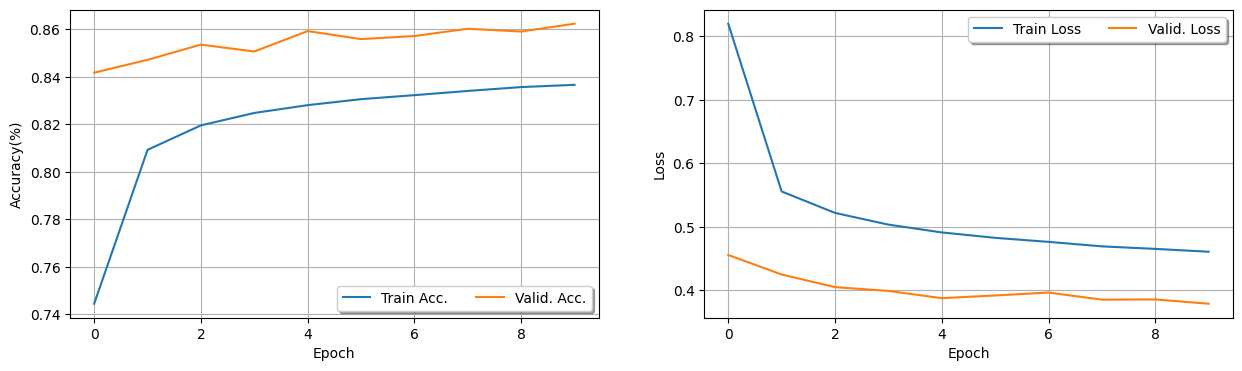

In [17]:
# Valeurs importantes lors de l'apprentissage du modèle
model_train_acc_cnn2 = model_cnn2_history.history['accuracy']
model_valid_acc_cnn2 = model_cnn2_history.history['val_accuracy']
model_train_loss_cnn2 = model_cnn2_history.history['loss']
model_valid_loss_cnn2 = model_cnn2_history.history['val_loss']

# Graphiques de l'apprentissage
fig,(ax0,ax1) = plt.subplots(1, 2, figsize=(15,4))

# Accuracy graph
ax0.plot(model_train_acc_cnn2, label="Train Acc.")
ax0.plot(model_valid_acc_cnn2, label="Valid. Acc.")

ax0.set_xlabel('Epoch')
ax0.set_ylabel('Accuracy(%)')
ax0.legend(loc='lower right', fancybox=True, shadow=True, ncol=4)
ax0.grid()

# Loss graph
ax1.plot(model_train_loss_cnn2, label="Train Loss")
ax1.plot(model_valid_loss_cnn2, label="Valid. Loss")

ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend(loc='upper right', fancybox=True, shadow=True, ncol=4)
ax1.grid()

### 3.2) Option B (Transfert Learning)

#### 3.2.1) Transfer Learning 1 (ResNet-50)

Pour la sélection des modèles,
nous nous sommes inspirés des recherches récentes sur des rapports de Transfert Learning
pour la reconnaissance d'images, notamment les travaux de Kaur, H., Sharma, R. et Kaur, J.

Bien entendu, comme nous ne disposons ni du matériel (GPU haute performance)
ni du temps d'apprentissage utilisé dans leurs expériences,
notre approche s'est concentrée sur la sélection des solutions les plus performantes
parmi les modèles rapides et légers.

Dans ce contexte, le modèle ResNet-50 est reconnu dans leurs recherche comme offrant un excellent
compromis entre performance et temps d'apprentissage,
en particulier pour les tâches de classification d'images avec un nombre limité d'époques.
C'est pourquoi nous avons choisi ce modèle pour notre premier test de "Transfer Learning".

https://www.nature.com/articles/s41598-024-74531-0#Sec6666

##### Modèle Feature Extraction

Lors de la première phase de Transfer Learning (feature extraction),
nous avons gelé l'intégralité des couches du modèle ResNet-50,
en ne ré-entraînant que la tête de classification que nous avons ajoutée (GlobalAveragePooling2D + Dense).

In [18]:
# Récupère les données d'entraînement
limite_taille = 50000

train_x, train_y, test_x, test_y, num_classes = data_preparation(train_data_emnist_byclass(limit=limite_taille), test_data_emnist_byclass(), True)
test_y = test_y [:limite_taille//10]
test_x = test_x [:limite_taille//10]

# Fonction d'augmentation pour le pipeline Transfer Learning
data_augmentation_fn = keras.Sequential([
    keras.layers.RandomRotation(0.02),
    keras.layers.RandomZoom(0.05),
])

# Fonction pour préprocessing compatible avec tf.data.Dataset (par image)
def preprocess_images_for_resnet_tf(image):
    # Si l'image est flatten → reshape
    image = tf.reshape(image, (28, 28, 1))

    # Resize en 128x128
    image = tf.image.resize(image, (128, 128))

    # Convertir en RGB
    image = tf.image.grayscale_to_rgb(image)

    # ResNet50 preprocessing (center crop + normalisation ImageNet compatible)
    image = resnet_preprocess(image)

    return image

# Paramètres batch car modifications de toutes les images trop lourd
batch_size = 32

# Crée le Dataset tf.data pour train
train_ds = tf.data.Dataset.from_tensor_slices((train_x, train_y))

train_ds = train_ds.map(
    lambda x, y: (data_augmentation_fn(tf.expand_dims(x, -1), training=True), y),  # appliquer augmentation
    num_parallel_calls=tf.data.AUTOTUNE
)

train_ds = train_ds.map(
    lambda x, y: (preprocess_images_for_resnet_tf(tf.squeeze(x, -1)), y),  # ensuite preprocessing ResNet
    num_parallel_calls=tf.data.AUTOTUNE
)

train_ds = train_ds.shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Crée le Dataset tf.data pour test
test_ds = tf.data.Dataset.from_tensor_slices((test_x, test_y))
test_ds = test_ds.map(lambda x, y: (preprocess_images_for_resnet_tf(x), y), num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Définir le modèle ResNet50V2
image_size = (128, 128)
input_shape = image_size + (3,)

base_model_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
base_model_resnet.trainable = False

# Architecture du modèle
inputs = Input(shape=input_shape)
x = base_model_resnet(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(num_classes, activation='softmax' if num_classes > 2 else 'sigmoid')(x)

model_resnet50_fe = Model(inputs, outputs)

# Compilation
model_resnet50_fe.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step


In [19]:
print("Training...")

# Callbacks
checkpoint_resnet_fe = ModelCheckpoint('./Result/Models/model_resnet50_fe_checkpoint.keras', save_best_only=True)
earlystop_resnet_fe = EarlyStopping(patience=5, restore_best_weights=True)

# Entrainement
history_resnet50_fe = model_resnet50_fe.fit(
    train_ds,
    validation_data=test_ds,  # <== idem
    epochs=3,
    callbacks=[checkpoint_resnet_fe, earlystop_resnet_fe]
)

# Sauvegarde du modèle
model_resnet50_fe.save('./Result/Models/model_resnet50_fe.keras')

# Résumé du modèle
model_resnet50_fe.summary()

print("Training finish")

Training...
Epoch 1/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 656s 417ms/step - accuracy: 0.0862 - loss: 3.7196 - val_accuracy: 0.3062 - val_loss: 2.7397
Epoch 2/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 642s 411ms/step - accuracy: 0.2340 - loss: 3.0009 - val_accuracy: 0.3994 - val_loss: 2.2536
Epoch 3/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 642s 411ms/step - accuracy: 0.2874 - loss: 2.7020 - val_accuracy: 0.4732 - val_loss: 1.9519


Model: "functional_68"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 4, 4, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 62)             │         7,998 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,398,524 (93.07 MB)

 Trainable params: 270,270 (1.03 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

 Optimizer params: 540,542 (2.06 MB)

Training finish


##### Tableau d'apprentissage (Feature Extraction)

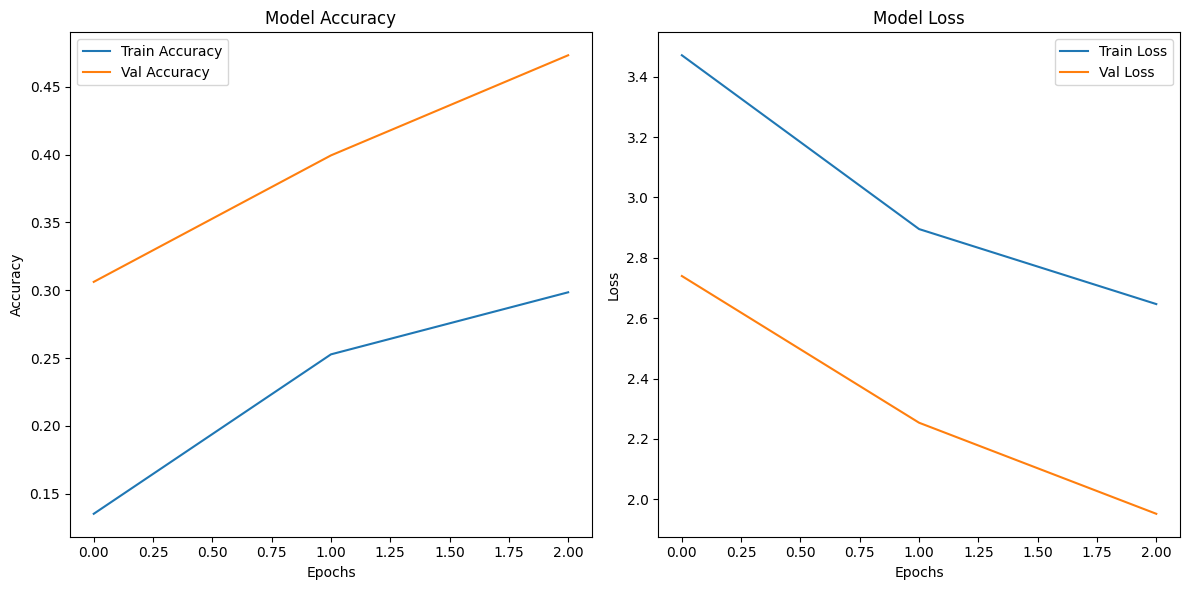

In [20]:
def plot_training_history(history):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history_resnet50_fe)

##### Modèle Fine-tuning

Pour l'étape de Fine-Tuning, nous avons choisi de décongeler certaines des couches
supérieures du modèle ResNet50, afin de permettre un entraînement plus fin
et mieux adapté à notre jeu de données spécifique, EMNIST ByClass.

Notre objectif était d'identifier un compromis entre la qualité des performances
et le temps d'entraînement, en tenant compte de la contrainte imposée par le projet
(30-40 minutes maximum).

Pour déterminer le nombre optimal de couches à décongeler,
nous avons effectué une série de tests : le modèle a été entraîné 8 fois,
en augmentant progressivement le nombre de couches décongelées par incréments de
10 couches supplémentaires à chaque essai.

Cette approche nous a permis d'observer l'impact du réglage fin sur la précision et
la stabilité du modèle.
Le meilleur compromis a été obtenu en décongelant
les 50 dernières couches du modèle : cette configuration a permis d'améliorer
la précision sans dépasser excessivement le temps d'entraînement ni provoquer de surajustement.

Pour la phase de fine-tuning, nous avons utilisé un taux d'apprentissage très faible (1e-5)
afin de permettre une adaptation progressive des couches supérieures (pas de surapprentissage).

In [21]:
print("Starting Fine-Tuning phase...")

# Dégeler une partie des couches du ResNet50
# On défreeze par exemple les 50 dernières couches (c'est un bon compromis)

base_model_resnet.trainable = True

# On freeze les premières couches, on ne garde que les 50 dernières entraînables
fine_tune_at = len(base_model_resnet.layers) - 50

for layer in base_model_resnet.layers[:fine_tune_at]:
    layer.trainable = False

print(f"Number of layers in the base model: {len(base_model_resnet.layers)}")
print(f"Fine-tuning from layer {fine_tune_at} to {len(base_model_resnet.layers)}")

# Re-compiler le modèle avec un learning rate très faible
model_resnet50_fe.compile(
    optimizer=Adam(learning_rate=1e-5),  # LR faible pour ne pas détruire les features pré-apprises
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks pour Fine-Tuning
checkpoint_resnet_ft = ModelCheckpoint('./Result/Models/model_resnet50_ft_checkpoint.keras', save_best_only=True)
earlystop_resnet_ft = EarlyStopping(patience=5, restore_best_weights=True)

# Entraînement Fine-Tuning
history_resnet50_ft = model_resnet50_fe.fit(
    train_ds,
    validation_data=test_ds,
    epochs=2,
    callbacks=[checkpoint_resnet_ft, earlystop_resnet_ft]
)

# Sauvegarde du modèle Fine-Tuned
model_resnet50_fe.save('./Result/Models/model_resnet50_ft.keras')

# Résumé du modèle (optionnel)
model_resnet50_fe.summary()

print("Fine-Tuning phase finished!")

Starting Fine-Tuning phase...
Number of layers in the base model: 175
Fine-tuning from layer 125 to 175
Epoch 1/2
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1180s 751ms/step - accuracy: 0.2964 - loss: 3.9109 - val_accuracy: 0.6244 - val_loss: 1.3163
Epoch 2/2
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1155s 739ms/step - accuracy: 0.5405 - loss: 1.6759 - val_accuracy: 0.6826 - val_loss: 1.0747


Model: "functional_68"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 4, 4, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 62)             │         7,998 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,299,580 (222.40 MB)

 Trainable params: 17,220,798 (65.69 MB)

 Non-trainable params: 6,637,184 (25.32 MB)

 Optimizer params: 34,441,598 (131.38 MB)

Fine-Tuning phase finished!


##### Tableau d'apprentissage (Fine-tuning)

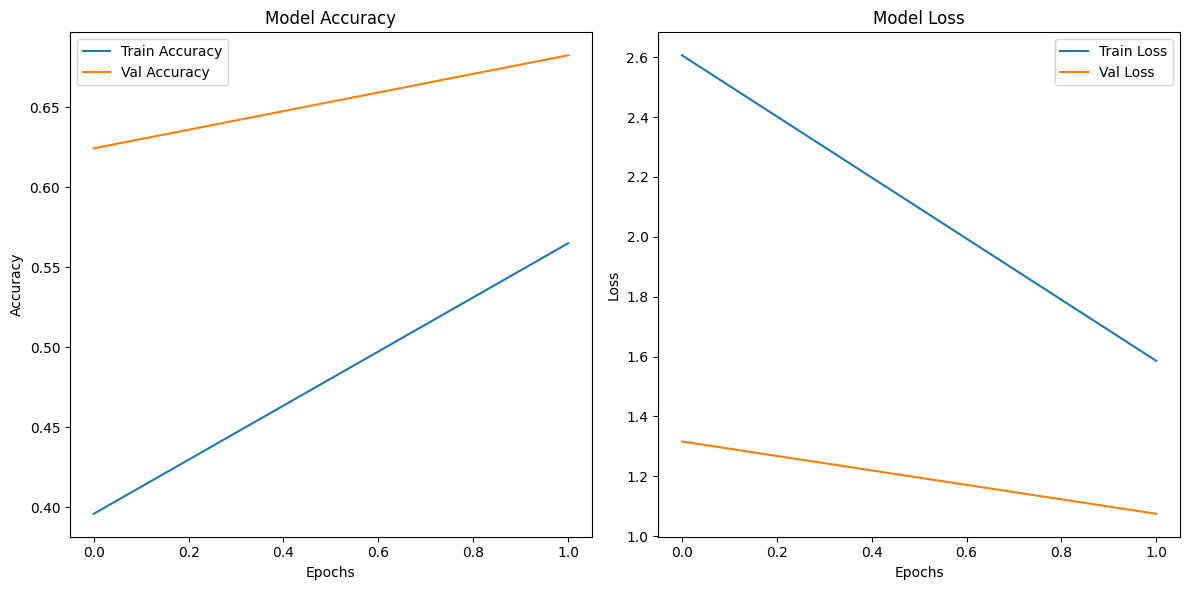

In [22]:
# Visualize the training history (accuracy and loss)
def plot_training_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# If fine-tuning was performed, visualize it as well
plot_training_history(history_resnet50_ft)

#### Observations
Nous pouvons observer que les résultats obtenus restent relativement faibles,
même après l'étape de Fine-Tuning.

La taille et la complexité du modèle rendent l'apprentissage long et gourmand en ressources.
Malgré l'utilisation du "fine  tunning" et des temps d'apprentissage prolongés,
nous avons constaté que le modèle avait du mal à converger efficacement sur ce type de données.
Il subsiste un risque important de overfitting.

Nous avons également effectué un test en laissant le modèle s'entraîner plus longtemps (>45 minutes) :
dans ce cas, la précision peut dépasser 80%.
Cependant, dans le contexte du projet,
avec une contrainte de temps d'entraînement de 30-40 minutes,
il est difficile d'atteindre une précision optimale sans ajuster davantage l'architecture ou utiliser un modèle plus léger,
mieux adapté à ce type de données.

#### 3.2.2) Transfer Learning 1 (MobileNetv2)

##### Modèle Feature Extraction

Au vu des problèmes que notre modèle précédent nous a posés lors de l'entraînement
en raison de sa taille excessive, nous avons décidé de prendre
le modèle le plus petit possible pour le deuxième modèle de transfer learning.

Notre idée était que, compte tenu de la simplicité de notre ensemble de données, les meilleurs résultats proviendraient
d'un modèle "plus simple".


In [23]:
# Définir la limite du dataset
limite_taille = 50000

# Chargement et préparation des données
train_x, train_y, test_x, test_y, num_classes = data_preparation(
    train_data_emnist_byclass(limit=limite_taille),
    test_data_emnist_byclass(),
    True
)

# Réduction de la taille du set de test
test_x = test_x[:limite_taille // 10]
test_y = test_y[:limite_taille // 10]


In [24]:
# Prétraitement d'une image pour MobileNetV2
def preprocess_images_for_mobilenet(image):
    image = tf.reshape(image, (28, 28, 1))                         # reshape image
    image = tf.image.resize(image, (224, 224))                    # resize
    image = tf.image.grayscale_to_rgb(image)                      # grayscale → RGB
    image = tf.cast(image, tf.float32)
    return image

data_augmentation_fn = keras.Sequential([
    keras.layers.RandomRotation(0.02),
    keras.layers.RandomZoom(0.05),
])


# Créer le tf.data.Dataset avec augmentation NICE
def create_tf_dataset_for_mobilenet(images, labels, batch_size=32, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices((images, labels))

    # 1. Augmentation
    ds = ds.map(lambda x, y: (data_augmentation_fn(tf.expand_dims(x, -1), training=True), y),
                num_parallel_calls=tf.data.AUTOTUNE)

    # 2. Preprocessing pour MobileNet
    ds = ds.map(lambda x, y: (preprocess_images_for_mobilenet(tf.squeeze(x, -1)), y),
                num_parallel_calls=tf.data.AUTOTUNE)

    # 3. Shuffle + batch + prefetch
    if shuffle:
        ds = ds.shuffle(buffer_size=len(images))
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return ds


In [25]:

# Création des Datasets
train_ds = create_tf_dataset_for_mobilenet(train_x, train_y)
test_ds = create_tf_dataset_for_mobilenet(test_x, test_y, shuffle=False)

# Création du modèle
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

model_mobilenet = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

model_mobilenet.compile(optimizer=Adam(learning_rate=1e-3),
                        loss='categorical_crossentropy' if num_classes > 2 else 'binary_crossentropy',
                        metrics=['accuracy'])


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [26]:
# Entraînement - Feature Extraction
history_fe = model_mobilenet.fit(
    train_ds,
    validation_data=test_ds,
    epochs=5,
    callbacks=[
        ModelCheckpoint('./Result/Models/model_mobilenet_fe_checkpoint.keras', save_best_only=True),
        EarlyStopping(patience=3, restore_best_weights=True)
    ]
)

model_mobilenet.save('./Result/Models/model_mobilenet_fe.keras')


Epoch 1/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 741s 421ms/step - accuracy: 0.5133 - loss: 1.8937 - val_accuracy: 0.7594 - val_loss: 0.7763
Epoch 2/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 757s 431ms/step - accuracy: 0.7222 - loss: 0.8927 - val_accuracy: 0.7818 - val_loss: 0.6628
Epoch 3/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 767s 437ms/step - accuracy: 0.7523 - loss: 0.7731 - val_accuracy: 0.7900 - val_loss: 0.6339
Epoch 4/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 769s 436ms/step - accuracy: 0.7616 - loss: 0.7216 - val_accuracy: 0.7862 - val_loss: 0.6235
Epoch 5/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 776s 434ms/step - accuracy: 0.7772 - loss: 0.6746 - val_accuracy: 0.7868 - val_loss: 0.6226


##### Tableau d'apprentissage (Feature Extraction)

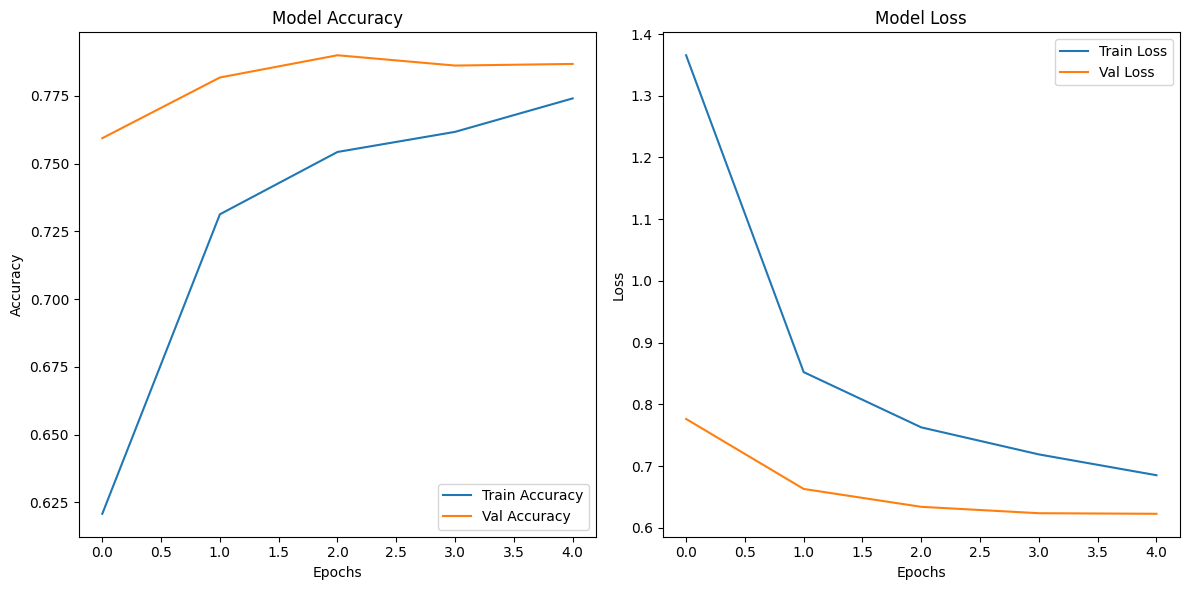

In [27]:
def plot_training_history(history):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history_fe)

##### Modèle Fine-tuning

In [28]:
# Fine-Tuning : dégèle uniquement les 30 dernières couches
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False

model_mobilenet.compile(optimizer=Adam(learning_rate=1e-5),
                        loss='categorical_crossentropy' if num_classes > 2 else 'binary_crossentropy',
                        metrics=['accuracy'])

history_ft = model_mobilenet.fit(
    train_ds,
    validation_data=test_ds,
    epochs=3,
    callbacks=[
        ModelCheckpoint('./Result/Models/model_mobilenet_ft_checkpoint.keras', save_best_only=True),
        EarlyStopping(patience=3, restore_best_weights=True)
    ]
)

model_mobilenet.save('./Result/Models/model_mobilenet_ft.keras')

Epoch 1/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 979s 564ms/step - accuracy: 0.5440 - loss: 1.8904 - val_accuracy: 0.7758 - val_loss: 0.6808
Epoch 2/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 969s 560ms/step - accuracy: 0.7584 - loss: 0.7417 - val_accuracy: 0.8102 - val_loss: 0.5538
Epoch 3/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 963s 559ms/step - accuracy: 0.7905 - loss: 0.6236 - val_accuracy: 0.8250 - val_loss: 0.5078


##### Tableau d'apprentissage (Fine-tuning)

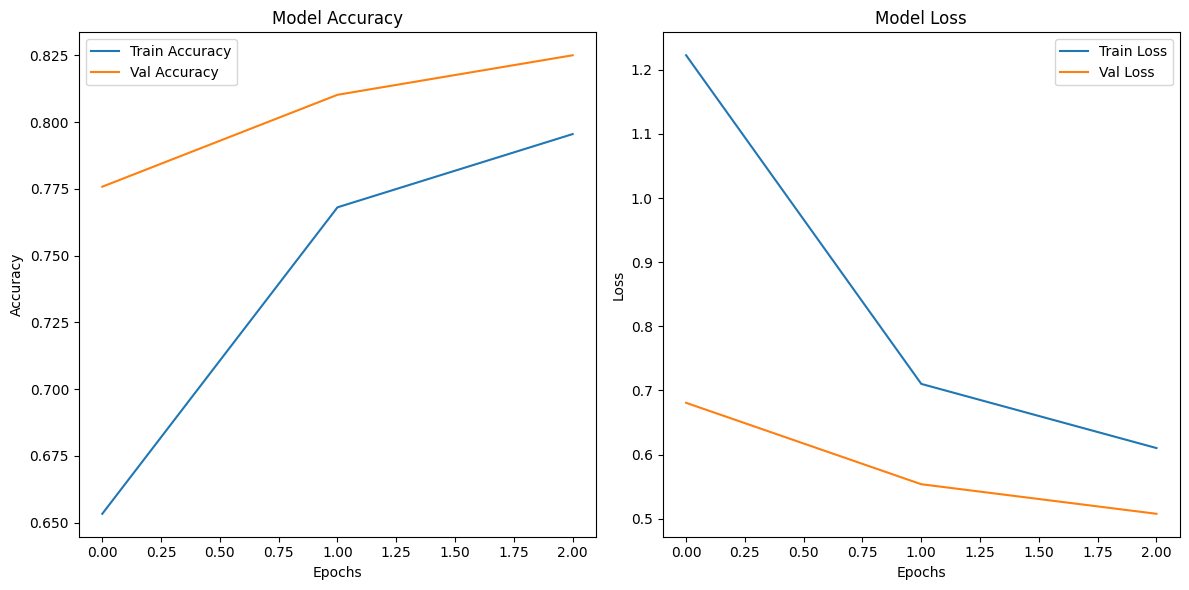

In [29]:
def plot_training_history(history):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history_ft)

## 4) Évaluation Comparative et Analyse Critique des modèles
---
### 4.1) Comparaison

| Modèle                    | Temps (minutes) | Val Accuracy (%) | Val Loss |
|---------------------------|----------------|------------------|----------|
| CNN1                      | ~39            | 85.94            | 0.3989   |
| CNN2                      | ~27             | 86.23            | 0.3789   |
| ResNet-50 (défaut)        | ~32             | 47.32            | 1.9519   |
| ResNet-50 (fine-tuning)   | ~38             | 68.26            | 1.0747   |
| MobileNetV2 (défaut)      | ~50             | 78.68            | 0.6226   |
| MobileNetV2 (fine-tuning) | ~47             | 82.50            | 0.5078   |


Tout les entrainements ont été fait sur 1 seule et même machine dont le processeur est un processeur Intel Core I7 1355U. <br>
La comparaison montre que les modèles CNN maisons continuent à donner les meilleurs résultats
pour notre ensemble de données, dans les limites de temps et de ressources imposées par le projet.

Les modèles de transfer learning, en particulier MobileNetV2,
ont néanmoins obtenu des résultats intéressants (près de 80 % de précision),
démontrant leur adaptabilité même sur des images binaires simples et de petite taille.
En revanche, ResNet-50, bien que plus puissant en théorie,
s'est avéré moins adapté dans ce contexte, probablement en raison
de sa complexité et de la nécessité d'une transformation poussée des images d'entrée.

Enfin, la taille réduite et la simplicité des architectures CNN internes restent
plus cohérentes pour traiter efficacement ce type de données (images binaires 28x28),
tout en permettant un apprentissage rapide et une bonne généralisation.

### 4.2) Quelle est l'approche globale la plus performante ?

Le modèle CNN2 est apparu comme le plus adapté à notre ensemble de données EMNIST ByClass.
Il offre une grande précision (>85 %) dans un délai raisonnable,
tout en étant plus légers et mieux adaptés aux petites images binaires.

### 4.3) Quel modèle pré-entraîné a donné les meilleurs résultats ? Pourquoi ?

Le modèle MobileNetV2 a donné les meilleurs résultats de tous les modèles pré-entraînés testés.
Sa structure plus légère et optimisée le rend mieux adapté au traitement
de petites images en niveaux de gris,
telles que celles de notre ensemble de données EMNIST ByClass.

De plus, dans le cadre de notre projet,
les contraintes en termes de temps d'entraînement et de
ressources matérielles favorisent l'utilisation de modèles plus compacts.
MobileNetV2 est donc un choix pertinent, offrant un bon compromis entre précision et rapidité

### 4.4) Le fine-tuning apporte-t-il une amélioration significative ?

Le fine-tuning a permis une légère amélioration du modèle MobileNetV2, augmentant la précision de 78% à 82%.
Cette amélioration modérée suggère que les couches pré-entraînées de MobileNetV2 étaient déjà bien adaptées à notre tâche après la premiere étape. Cette modification a donc permis un ajustement plus fin sans transformer radicalement les performances.

A l'inverse, sur le modèle ResNet-50, le Fine-Tuning a apporté une amélioration plus marquée, montrant que ce type d'architecture plus lourde nécessite un réglage plus profond pour s'adapter à un jeu de données aussi spécifique que EMNIST.

### 4.5) Avantages / inconvénients par approche :

| Approche                       | Avantages                                                       | Inconvénients                                         |
| ------------------------------ | --------------------------------------------------------------- | ----------------------------------------------------- |
| CNN Maison                     | Efficace, rapide, adapté aux images 28x28                       | Moins généralisable à des images plus complexes       |
| ResNet-50 Feature Extraction   | Facile à implémenter, peu de risque d'overfitting               | Faible précision sur EMNIST                           |
| ResNet-50 Fine-Tuning          | Améliore les performances par adaptation                        | Temps d'entraînement long, surcoût mémoire            |
| MobileNetV2 Feature Extraction | Léger, rapide à entraîner, bonne précision sur petites images   | Moins performant sur des classes visuellement proches |
| MobileNetV2 Fine-Tuning        | Optimise les performances sans allonger le temps d'entraînement | Gains limités par rapport à la Feature Extraction     |


3636/3636 ━━━━━━━━━━━━━━━━━━━━ 25s 7ms/step


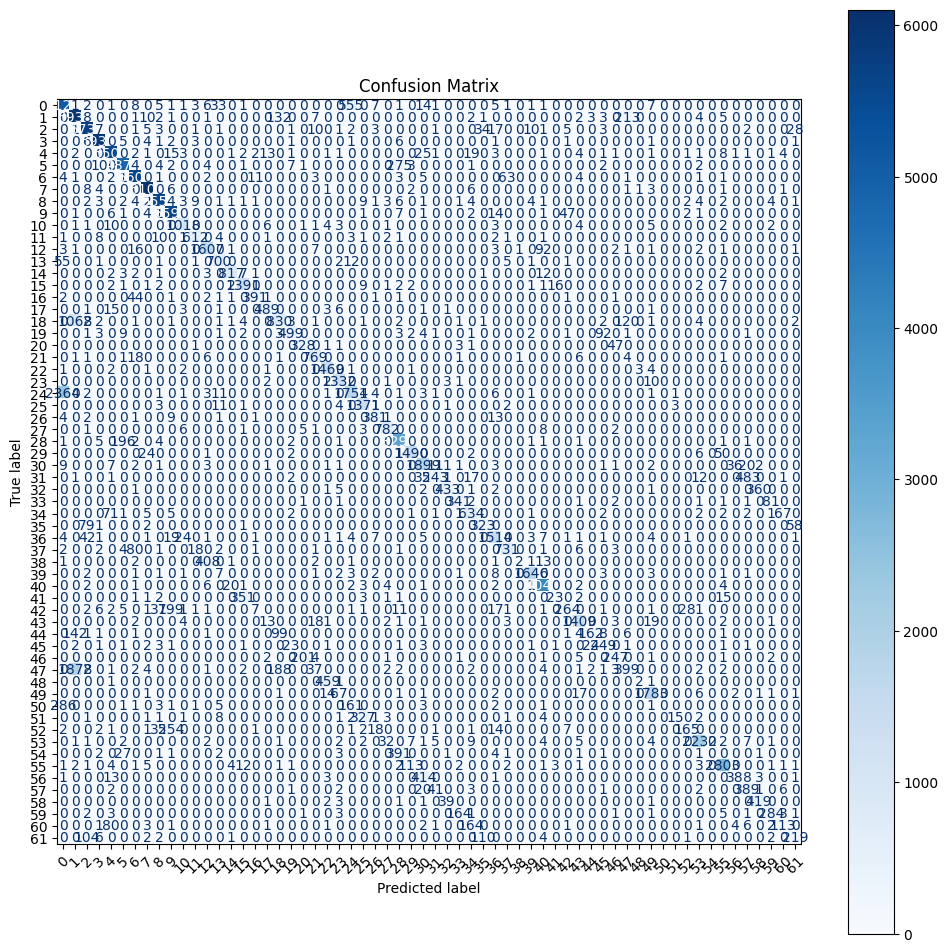

In [37]:
def plot_confusion_matrix_full(model, test_x, test_y, class_names=None):
    # Prédictions
    preds = model.predict(test_x)
    if preds.shape[1] > 1:
        preds = np.argmax(preds, axis=1)
        y_true = np.argmax(test_y, axis=1)
    else:
        preds = (preds > 0.5).astype("int32").flatten()
        y_true = test_y.flatten()

    # Matrice de confusion
    cm = confusion_matrix(y_true, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

    # Plot
    fig, ax = plt.subplots(figsize=(12, 12))
    disp.plot(ax=ax, cmap='Blues', xticks_rotation=45)
    plt.title("Confusion Matrix")
    plt.show()

model_for_matrix = load_model("./Result/Models/model_cnn2.keras")
train_x, train_y, test_x, test_y, num_classes = data_preparation(train_data_emnist_byclass(), test_data_emnist_byclass(), True)

plot_confusion_matrix_full(model_for_matrix, test_x, test_y)

La matrice de confusion n'est hélas pas tres visuelle vu le nombre de classe (62) mais la diagonale
reste suffisament visible pour voir que la majoritée des prédictions sont correctes.

### 4.6) Meilleur modèle global obtenu ?

Le modèle **CNN2**, avec une précision de 87%, est le meilleur modèle pour notre tâche.
Il présente un bon compromis entre performance, temps d'entraînement,
et adéquation avec la nature des données.

## 5)Application réel du projet
---

### 5.1) Vidéo

In [38]:
# Extraction de la lettre / forme à partir d'une vidéo via la reconnaissance image au niveau de la main
def traitement_video(video_path, final_letter_frame, frame_interval=2):
    # === 1. Extraction des frames ===
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Erreur : impossible d'ouvrir la vidéo '{video_path}'")
        exit()

    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    print(f"Vidéo chargée : {total_frames} frames à {fps:.2f} fps")

    # === 2. Initialisation ===
    trace_points = []
    frame_count = 0
    saved_count = 0
    img_shape = None
    detector = HandDetector(staticMode=True, maxHands=1, detectionCon=0.7)

    # === 3. Parcours des frames en mémoire ===
    while True:
        success, frame = cap.read()
        if not success:
            break

        if frame_count % frame_interval == 0:
            image = frame.copy()
            hands, img = detector.findHands(image)

            if hands:
                hand = hands[0]
                lm_list = hand['lmList']
                if len(lm_list) >= 9:
                    x, y = lm_list[8][0], lm_list[8][1]
                    trace_points.append((x, y))

            if img_shape is None:
                img_shape = img.shape

            saved_count += 1

        frame_count += 1

    cap.release()
    print(f"{saved_count} images traitées")

    # === 4. Génération de l'image composite ===
    height, width, _ = img_shape
    result = np.zeros((height, width, 3), dtype=np.uint8)

    for i in range(1, len(trace_points)):
        cv2.line(result, trace_points[i - 1], trace_points[i], (0, 0, 255), thickness=6)

    # === 5. Rotation de 90° vers la droite ===
    rotated = cv2.rotate(result, cv2.ROTATE_90_CLOCKWISE)

    # === 6. Effet miroir (symétrie horizontale) ===
    mirrored = cv2.flip(rotated, 1)

    # === 7. Sauvegarde de l'image finale ===
    cv2.imwrite(final_letter_frame, mirrored)
    print(f"Image finale enregistrée sous '{final_letter_frame}' ({total_frames} frames à {fps:.2f} fps ,Images traitées = {saved_count})")

# Extraction des lettres dans toutes les vidéos présent dans le dossier vidéo
video_folder = './Result/videos/Lettres/'
path_letter_frame = './Result/Hand_Detected_Images/'
os.makedirs(path_letter_frame, exist_ok=True)
compteur = 0

for name_folder in sorted(os.listdir(video_folder)):
    if name_folder.lower().endswith('.mp4'):
        video_path = os.path.join(video_folder, name_folder)
        lettre_video = os.path.splitext(name_folder)[0]
        path_letter_frame_good = f'{path_letter_frame}{lettre_video}.png'
        traitement_video(video_path, path_letter_frame_good, 2)
        compteur += 1

print(f"Traitement de {compteur} videos terminé")


Vidéo chargée : 521 frames à 60.00 fps
261 images traitées
Image finale enregistrée sous './Result/Hand_Detected_Images/A.png' (521 frames à 60.00 fps ,Images traitées = 261)
Vidéo chargée : 437 frames à 60.00 fps
219 images traitées
Image finale enregistrée sous './Result/Hand_Detected_Images/B.png' (437 frames à 60.00 fps ,Images traitées = 219)
Vidéo chargée : 293 frames à 60.00 fps
147 images traitées
Image finale enregistrée sous './Result/Hand_Detected_Images/C.png' (293 frames à 60.00 fps ,Images traitées = 147)
Vidéo chargée : 536 frames à 60.00 fps
268 images traitées
Image finale enregistrée sous './Result/Hand_Detected_Images/D.png' (536 frames à 60.00 fps ,Images traitées = 268)
Vidéo chargée : 534 frames à 60.00 fps
267 images traitées
Image finale enregistrée sous './Result/Hand_Detected_Images/E.png' (534 frames à 60.00 fps ,Images traitées = 267)
Vidéo chargée : 278 frames à 60.00 fps
139 images traitées
Image finale enregistrée sous './Result/Hand_Detected_Images/F.png

In [39]:
# Affichage des images de lettres extraites de vidéos
# === Paramètres ===
image_dir = './Result/Hand_Detected_Images'

# === Récupération des images ===
image_files = sorted([
    f for f in os.listdir(image_dir)
    if f.lower().endswith('.png')
])

# === Création de la figure ===
fig, axes = plt.subplots(4, 7, figsize=(100, 80))
axes = axes.flatten()

for i, ax in enumerate(axes):
    if i < len(image_files):
        image_path = os.path.join(image_dir, image_files[i])
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        ax.imshow(image)

plt.tight_layout()
plt.show()

### 5.2) Traitements d'image
Standardisation des lettres dessinées, extraites des vidéos ci-dessus afin d'avoir le format 28x28 pixels comme le dataset EMNIST sur lequel notre modèle c'est entrainé.

In [40]:
# Step 1: Extract red from image
def extract_red_mask(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    lower_red1 = np.array([0, 70, 50])
    upper_red1 = np.array([10, 255, 255])
    lower_red2 = np.array([170, 70, 50])
    upper_red2 = np.array([180, 255, 255])
    mask1 = cv2.inRange(hsv, lower_red1, upper_red1)
    mask2 = cv2.inRange(hsv, lower_red2, upper_red2)
    return cv2.bitwise_or(mask1, mask2)

# Step 2: Basic cleaning (open/close)
def clean_mask(mask):
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    return cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

# Step 3: Keep relevant parts
def filter_components(mask, min_area=20):
    labeled = label(mask)
    cleaned = np.zeros_like(mask)
    for region in regionprops(labeled):
        if region.area >= min_area:
            for y, x in region.coords:
                cleaned[y, x] = 255
    return cleaned

# Step 4: Skeletonize
def get_skeleton(mask):
    return (skeletonize(mask > 0) * 255).astype(np.uint8)

# Step 5 : Bold the ligne
def thicken_mask(mask, size=2):
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (size, size))
    return cv2.dilate(mask, kernel, iterations=1)

# Step 6: Resize and center
def center_crop_and_scale(mask, output_size=28, margin=20):
    # Trouver les contours
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return np.zeros((output_size, output_size), dtype=np.uint8)

    # Bounding box autour du plus grand contour
    x, y, w, h = cv2.boundingRect(max(contours, key=cv2.contourArea))

    # Calcul carré englobant avec marge
    max_dim = max(w, h) + margin
    center_x, center_y = x + w // 2, y + h // 2
    half = max_dim // 2

    # Bords du carré
    top = max(center_y - half, 0)
    bottom = min(center_y + half, mask.shape[0])
    left = max(center_x - half, 0)
    right = min(center_x + half, mask.shape[1])

    # Crop carré
    cropped = mask[top:bottom, left:right]

    # Redimensionnement à 28x28
    resized = cv2.resize(cropped, (output_size, output_size), interpolation=cv2.INTER_AREA)

    return resized

# Main function
def process_image(path, save_step=False):
    list_step = []
    img = cv2.imread(path)

    mask = extract_red_mask(img)

    cleaned = clean_mask(mask)

    filtered = filter_components(cleaned)

    skeleton = get_skeleton(filtered)

    thickened = thicken_mask(skeleton, size=100)

    final = center_crop_and_scale(thickened, margin=300, output_size=28)

    if save_step:
        list_step.extend([img, mask, cleaned, filtered, skeleton, thickened, final])
        # list_step.extend([img, mask, cleaned, filtered, thickened, final])
        return list_step
    return final

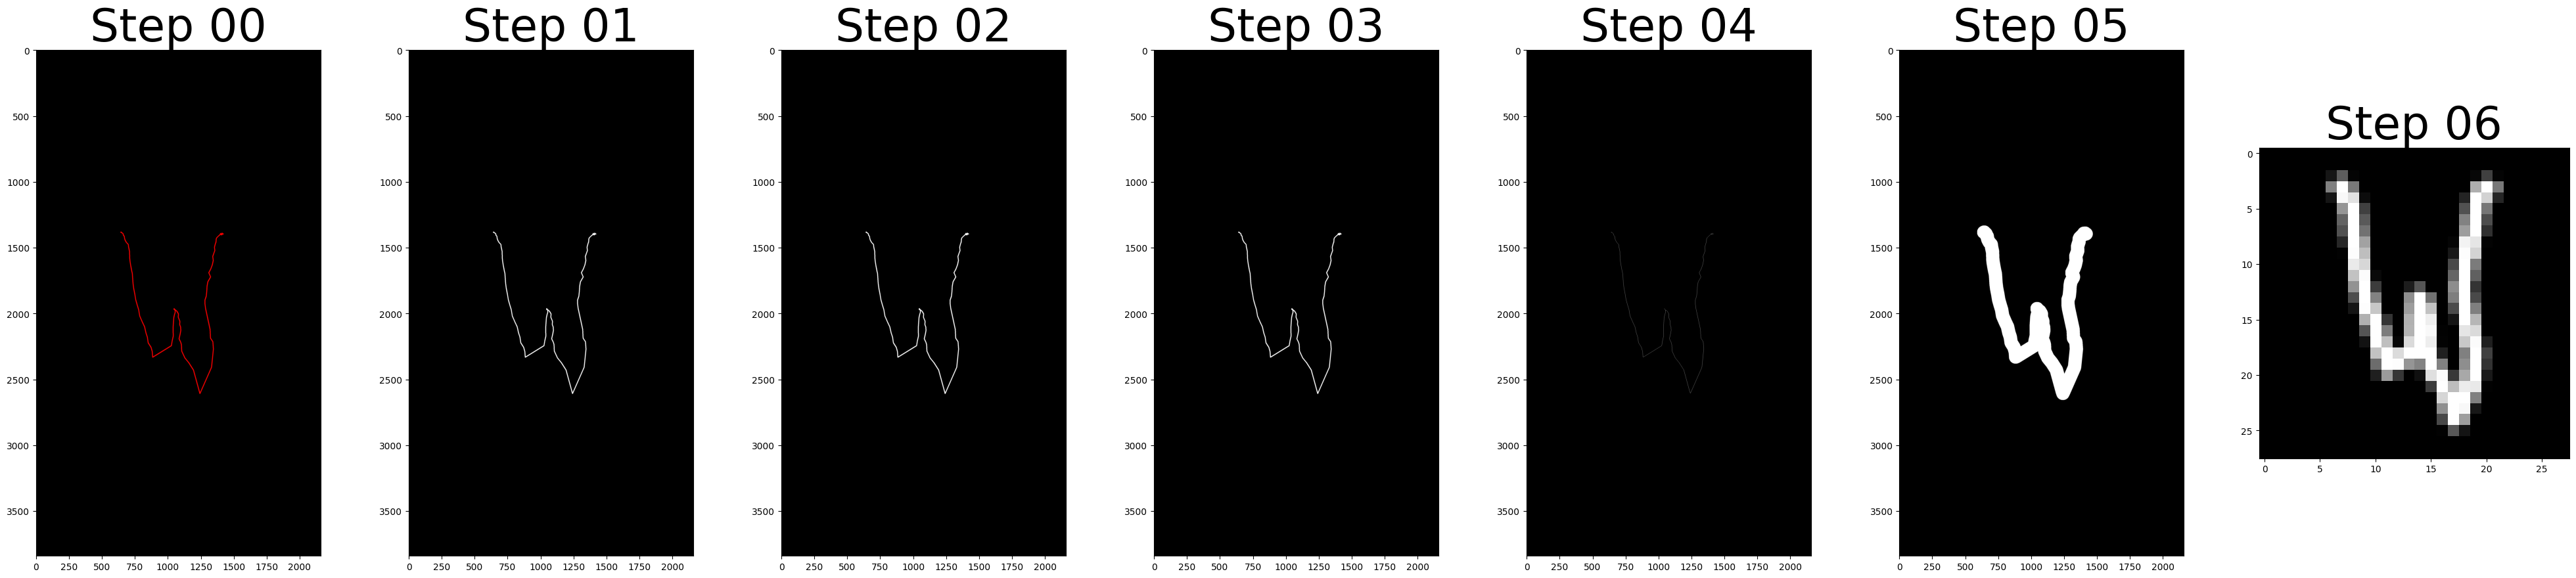

In [34]:
# Différentes étapes du traitement d'image
# === Paramètres ===
image_dir = process_image("./Result/Hand_Detected_Images/W.png", save_step=True)

# === Création de la figure ===
fig, axes = plt.subplots(1, 7, figsize=(50, 10))
axes = axes.flatten()
i = 0

for i, ax in enumerate(axes):
    img = image_dir[i]

    # Si l'image est en niveaux de gris
    if len(img.shape) == 2:
        ax.imshow(img, cmap='gray')
    else:
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax.imshow(img_rgb)
    ax.set_title(f"Step {i:02d}", fontsize=50)

plt.show()

Pour pouvoir donner l'image traité à notre modèle entrainé nous devons la préparer au format attendu par le modele.

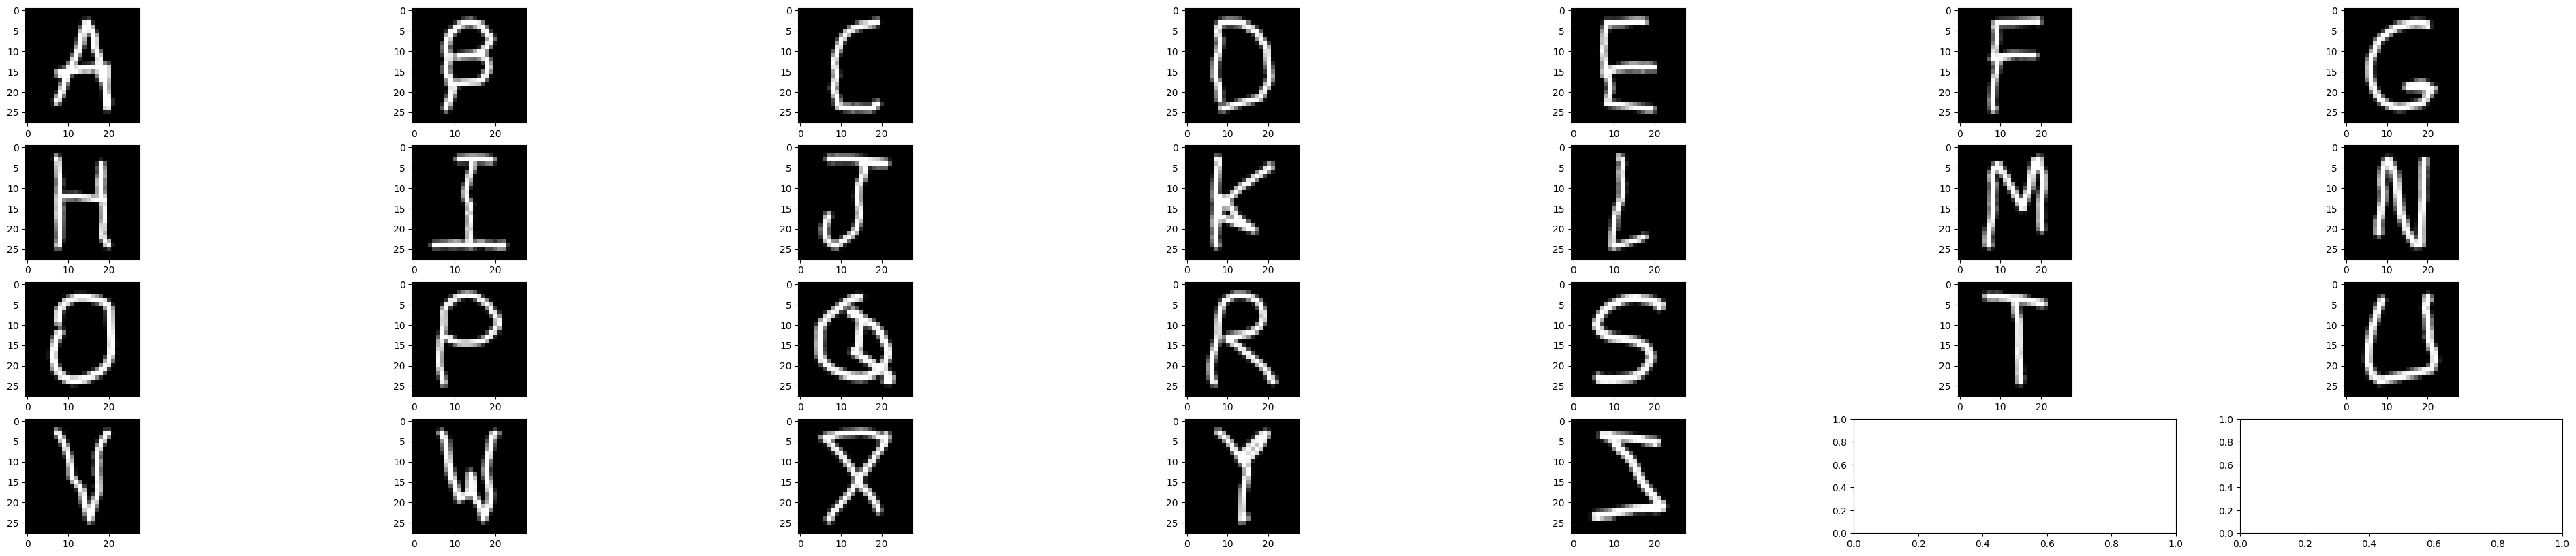

In [41]:
# Creation du dataset comprenant les images traité extraites des vidéos
image_folder = './Result/Hand_Detected_Images/'
data_samples = []
fig, axes = plt.subplots(4, 7, figsize=(50, 10))
axes = axes.flatten()
i = 0

for name_folder in sorted(os.listdir(image_folder)):
    if name_folder.lower().endswith('.png'):
        letter_label = os.path.splitext(name_folder)[0]
        image_path = f'{image_folder}{letter_label}.png'

        # Traitement image 28x28 et affichage des images traité
        processed_img  = process_image(image_path)
        ax = axes[i]
        ax.imshow(processed_img,cmap='gray')
        i += 1

        # Stockage des lettre
        data_samples.append((letter_label, processed_img))

# Affichage des lettres après traitement
plt.show()

### 5.3) Application du Meilleur Modèle entrainé sur la reconnaissance d'image


- Expected "A"; Predicted: "A" (99.76%) | 2nd: "H" (0.22%)


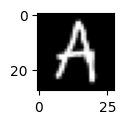

- Expected "B"; Predicted: "P" (97.17%) | 2nd: "p" (2.60%)


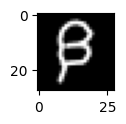

- Expected "C"; Predicted: "C" (89.22%) | 2nd: "c" (9.93%)


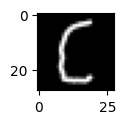

- Expected "D"; Predicted: "D" (98.99%) | 2nd: "0" (0.77%)


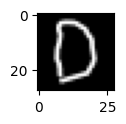

- Expected "E"; Predicted: "E" (99.93%) | 2nd: "F" (0.06%)


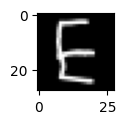

- Expected "F"; Predicted: "F" (96.69%) | 2nd: "f" (3.31%)


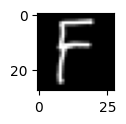

- Expected "G"; Predicted: "G" (82.13%) | 2nd: "6" (17.86%)


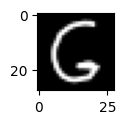

- Expected "H"; Predicted: "H" (99.99%) | 2nd: "h" (0.01%)


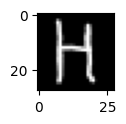

- Expected "I"; Predicted: "I" (99.95%) | 2nd: "l" (0.03%)


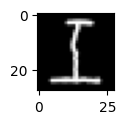

- Expected "J"; Predicted: "J" (99.93%) | 2nd: "j" (0.07%)


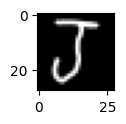

- Expected "K"; Predicted: "K" (85.23%) | 2nd: "k" (14.76%)


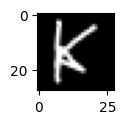

- Expected "L"; Predicted: "L" (96.90%) | 2nd: "l" (2.76%)


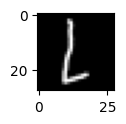

- Expected "M"; Predicted: "M" (99.66%) | 2nd: "m" (0.24%)


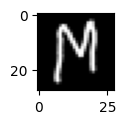

- Expected "N"; Predicted: "N" (99.93%) | 2nd: "n" (0.03%)


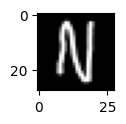

- Expected "O"; Predicted: "0" (84.56%) | 2nd: "O" (14.52%)


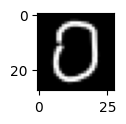

- Expected "P"; Predicted: "P" (98.75%) | 2nd: "p" (1.25%)


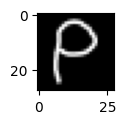

- Expected "Q"; Predicted: "Q" (84.84%) | 2nd: "G" (12.39%)


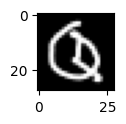

- Expected "R"; Predicted: "R" (99.98%) | 2nd: "r" (0.01%)


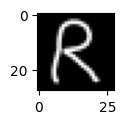

- Expected "S"; Predicted: "S" (64.37%) | 2nd: "5" (30.47%)


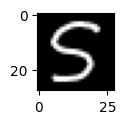

- Expected "T"; Predicted: "T" (99.93%) | 2nd: "t" (0.06%)


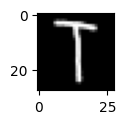

- Expected "U"; Predicted: "U" (97.85%) | 2nd: "u" (2.12%)


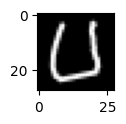

- Expected "V"; Predicted: "Y" (68.85%) | 2nd: "V" (26.46%)


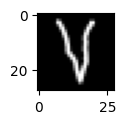

- Expected "W"; Predicted: "W" (36.66%) | 2nd: "V" (20.63%)


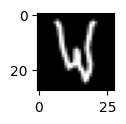

- Expected "X"; Predicted: "X" (78.11%) | 2nd: "x" (12.38%)


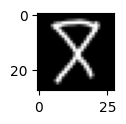

- Expected "Y"; Predicted: "Y" (99.83%) | 2nd: "y" (0.16%)


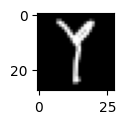

- Expected "Z"; Predicted: "J" (78.63%) | 2nd: "I" (6.77%)


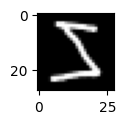


Accuracy: 22/26 (84.62%)


In [42]:
correct = []

model_for_predict = load_model("./Result/Models/model_cnn2.keras")
label_mapping = label_mapping_emnist_byclass()
# !!! Attention a bien changer pour que le type de DataSet d'entrainement sois le même que le label_mapping !!!

label_trans = {}
for label_m in label_mapping:
    label_trans[label_m[0]] = chr(int(label_m[1]))

for true_label, img in data_samples:
    x = img.reshape(1, 28, 28, 1) / 255.0
    res = model_for_predict.predict(x, verbose=0).reshape(-1)
    res_ind = np.flip(np.argsort(res))

    pred_char_1 = label_trans[res_ind[0]]
    pred_char_2 = label_trans[res_ind[1]]

    if true_label == pred_char_1:
        correct.append(label)

    print(f'- Expected "{true_label}"; Predicted: "{pred_char_1}" ({res[res_ind[0]]*100:.2f}%) | 2nd: "{pred_char_2}" ({res[res_ind[1]]*100:.2f}%)')
    plt.figure(figsize=(1,1))
    plt.imshow(img, cmap='gray')
    plt.show()

print(f'\nAccuracy: {len(correct)}/{len(data_samples)} ({100 * len(correct)/len(data_samples):.2f}%)')


## 6) Conclusions et Décisions
---
Le projet nous a permis d'explorer et de comparer différentes approches de la classification d'images sur un problème concret.

Nous avons expérimenté deux grandes familles de modèles :
les CNNs, optimisés pour notre jeu de données spécifique (images binaires 28x28),
des modèles d'apprentissage par transfert (ResNet-50, MobileNet).

Les résultats montrent que les modèles CNN internes sont mieux adaptés à ce type de données simples,
avec des performances élevées et un temps d'apprentissage raisonnable.
Les modèles d'apprentissage par transfert,
bien que puissants sur des images naturelles complexes,
sont moins efficaces ici en raison de la nécessité de transformer fortement nos images
(redimensionnement, conversion en RVB), ce qui perturbe les caractéristiques ImageNet préapprises.

Lors du test final avec de nouvelles images capturées en conditions réelles,
le meilleur modèle a atteint une précision de 84,62% (22/26).
Les erreurs restantes sont essentiellement dues à la proximité visuelle de certaines classes
(par exemple “O” et “0”, “2” et “Z”),
qui correspondent à des ambiguïtés également perceptibles par un humain.

Ces résultats confirment la pertinence de l'approche CNN interne pour ce type de tâche.
Ils mettent également en évidence les limites des modèles pré-entraînés lorsqu'ils sont appliqués
à des domaines très différents de leur domaine d'origine.

Ce projet nous a permis de comprendre le fonctionnement de Transfer learning et l'importance de bien
comprendre le but de l'ia pour pouvoir utiliser un model adapté. Aussi nous avons pu tester l'importance
du testing lors de la mise en place de solution ai pour trouver les meilleurs parametres.